# Determination of a perspective tariff for a telecom company

Customers are offered two tariff plans: "Smart" and "Ultra". To adjust the advertising budget, the commercial department wants to understand which tariff brings in more money.

The project conducted a preliminary analysis of tariffs on a small sample of customers. We have the data of 500 Megalyne users at our disposal: who they are, where they come from, what tariff they use, how many calls and messages each sent in 2018. An analysis of customer behavior will be conducted and a conclusion will be made — which tariff is better.

<font size="4"><b>Description of tariffs</b></font>

**"Smart" tariff**:

1) Monthly fee: 550 rubles

2) Included 500 minutes of conversation, 50 messages and 15 GB of Internet traffic

3) The cost of services in excess of the tariff package:
* a minute of conversation: 3 rubles
* message: 3 rubles
* 1 GB of Internet traffic: 200 rubles

**"Ultra" tariff**

1) Monthly fee: 1950 rubles

2) 3000 minutes of conversation, 1000 messages and 30 GB of Internet traffic are included

3) The cost of services in excess of the tariff package:
* a minute of conversation: 1 ruble
* message: 1 ruble
* 1 GB of Internet traffic: 150 rubles

<font size="3"><b>Data description:</b></font>

Users table (information about users):
- `user_id` — unique user ID
- `first_name` — user name
- `last_name` — last name of the user
- `age` — user's age (years)
- `reg_date` — tariff activation date (day, month, year)
- `churn_date` — date of termination of use of the tariff (if the value is omitted, the tariff was still valid at the time of data upload)
- `city` — the user's city of residence
- `tariff` — name of the tariff plan

Calls table (information about calls):
- `id` — unique call number
- `call_date` — date of the call
- `duration` — the duration of the call in minutes
- `user_id` — id of the user who made the call

Messages table (information about messages):
- `id` — unique message number
- `message_date` — date of the message
- `user_id` — id of the user who sent the message

Internet table (information about internet sessions):
- `id` — unique session number
- `mb_used` — the amount of Internet traffic spent per session (in megabytes)
- `session_date` — date of the internet session
- `user_id` — user ID

Tariffs table (information about tariffs):
- `tariff_name` — name of the tariff
- `rub_monthly_fee` — monthly subscription fee in rubles
- `minutes_included` — the number of minutes of conversation per month included in the subscription fee
- `messages_included` — the number of messages per month included in the subscription fee
- `mb_per_month_included` — the amount of Internet traffic included in the subscription fee (in megabytes)
- `rub_per_minute` — the cost of a minute of conversation over the tariff package (for example, if the tariff has 100 minutes of conversation per month, then a fee will be charged from 101 minutes)
- `rub_per_message` — the cost of sending a message over the tariff package
- `rub_per_gb` — the cost of an additional gigabyte of Internet traffic over the tariff package (1 gigabyte = 1024 megabytes)

## Step 1. Open the data files and study the general information

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import matplotlib.pyplot as plt

In [2]:
users = pd.read_csv('datasets/users.csv', parse_dates=['churn_date','reg_date'])
display(users.head())
print(users.info())

calls = pd.read_csv('datasets/calls.csv', parse_dates=['call_date'])
display(calls.head())
print(calls.info())

messages = pd.read_csv('datasets/messages.csv', parse_dates=['message_date'])
display(messages.head())
print(messages.info())

internet = pd.read_csv('datasets/internet.csv', parse_dates=['session_date'], index_col=0)
display(internet.head())
print(internet.info())

tariffs = pd.read_csv('datasets/tariffs.csv')
display(tariffs.head())
print(tariffs.info())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaT,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaT,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB
None


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB
None


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB
None


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB
None


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
None


We loaded the data of five tables:
* in read_csv(), we set parse_dates, so that the columns with the date immediately took the desired format;
* when reading the internet table, index_col=0 was specified

## Step 2. Data preparation

### Preparation of the table "Calls"

In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


In [5]:
calls['duration'] = np.ceil(calls['duration']).astype('int')

*It is necessary to round up the duration before summing. This is consistent with how the operator fixes revenue.*

In [6]:
calls['year'] = pd.DatetimeIndex(calls['call_date']).year
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
calls['day'] = pd.DatetimeIndex(calls['call_date']).day
calls.head()

,id,call_date,duration,user_id,year,month,day
0,1000_0,2018-07-25,0,1000,2018,7,25
1,1000_1,2018-08-17,0,1000,2018,8,17
2,1000_2,2018-06-11,3,1000,2018,6,11
3,1000_3,2018-09-21,14,1000,2018,9,21
4,1000_4,2018-12-15,6,1000,2018,12,15


Number and duration of calls of each user by month:

In [7]:
calls_pivot = pd.pivot_table(data = calls, index =['user_id','month'] , values = 'duration', aggfunc =['sum','count']).reset_index()
calls_pivot.columns = ['user_id','month','sum_calls','count_calls']
calls_pivot

,user_id,month,sum_calls,count_calls
0,1000,5,159,22
1,1000,6,172,43
2,1000,7,340,47
3,1000,8,408,52
4,1000,9,466,58
...,...,...,...,...
3169,1498,10,247,41
3170,1499,9,70,9
3171,1499,10,449,68
3172,1499,11,612,74


### Preparation of the table "Messages"

In [8]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [9]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


In [10]:
messages['year'] = pd.DatetimeIndex(messages['message_date']).year
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
messages['day'] = pd.DatetimeIndex(messages['message_date']).day
messages.head()

,id,message_date,user_id,year,month,day
0,1000_0,2018-06-27,1000,2018,6,27
1,1000_1,2018-10-08,1000,2018,10,8
2,1000_2,2018-08-04,1000,2018,8,4
3,1000_3,2018-06-16,1000,2018,6,16
4,1000_4,2018-12-05,1000,2018,12,5


Number of messages of each user by month:

In [11]:
messages_pivot = pd.pivot_table(data = messages, index =['user_id','month'] , values = 'year', aggfunc ='count').reset_index()
messages_pivot.columns = ['user_id','month','count_messages']
messages_pivot

,user_id,month,count_messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


### Preparation of the table "Internet"

In [12]:
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [13]:
internet['mb_used'].value_counts()

0.00      19598
335.91        9
447.30        9
197.56        9
199.11        8
          ...  
643.43        1
973.04        1
834.51        1
777.30        1
23.72         1
Name: mb_used, Length: 70003, dtype: int64

*Zero values in the table with Internet traffic can be caused by both a technical failure and a situation when a person tried to access the Internet, but something happened with the connection and the Internet session was instantly interrupted.*

In [14]:
internet['year'] = pd.DatetimeIndex(internet['session_date']).year
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
internet['day'] = pd.DatetimeIndex(internet['session_date']).day
internet.head()

,id,mb_used,session_date,user_id,year,month,day
0,1000_0,112.95,2018-11-25,1000,2018,11,25
1,1000_1,1052.81,2018-09-07,1000,2018,9,7
2,1000_2,1197.26,2018-06-25,1000,2018,6,25
3,1000_3,550.27,2018-08-22,1000,2018,8,22
4,1000_4,302.56,2018-09-24,1000,2018,9,24


GB and MB of each user by month:

In [15]:
internet_pivot = pd.pivot_table(data = internet, index =['user_id','month'] , values = 'mb_used', aggfunc ='sum').reset_index()
internet_pivot.columns = ['user_id','month','sum_mb']
internet_pivot['sum_gb'] =np.ceil(internet_pivot['sum_mb']/1024)
internet_pivot

,user_id,month,sum_mb,sum_gb
0,1000,5,2253.49,3.0
1,1000,6,23233.77,23.0
2,1000,7,14003.64,14.0
3,1000,8,14055.93,14.0
4,1000,9,14568.91,15.0
...,...,...,...,...
3198,1498,10,20579.36,21.0
3199,1499,9,1845.75,2.0
3200,1499,10,17788.51,18.0
3201,1499,11,17963.31,18.0


Monthly indicators are calculated. Traffic is also rounded correctly. The data is prepared for further calculations.

### Combine the prepared data

In [16]:
total_info = calls_pivot.merge(messages_pivot, on=['user_id','month'], how='outer')
total_info = total_info.merge(internet_pivot, on=['user_id','month'], how='outer')
total_info = total_info.fillna(0)
total_info

,user_id,month,sum_calls,count_calls,count_messages,sum_mb,sum_gb
0,1000,5,159.0,22.0,22.0,2253.49,3.0
1,1000,6,172.0,43.0,60.0,23233.77,23.0
2,1000,7,340.0,47.0,75.0,14003.64,14.0
3,1000,8,408.0,52.0,81.0,14055.93,14.0
4,1000,9,466.0,58.0,57.0,14568.91,15.0
...,...,...,...,...,...,...,...
3209,1489,9,0.0,0.0,32.0,17206.30,17.0
3210,1489,10,0.0,0.0,21.0,19559.44,20.0
3211,1489,11,0.0,0.0,20.0,17491.56,18.0
3212,1489,12,0.0,0.0,35.0,17322.51,17.0


It is the **outer** connection that we need in this case. Otherwise, customers who have not used one of the operator's services during a particular month will not be included in the table.

In [17]:
total_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         3214 non-null   int64  
 1   month           3214 non-null   int64  
 2   sum_calls       3214 non-null   float64
 3   count_calls     3214 non-null   float64
 4   count_messages  3214 non-null   float64
 5   sum_mb          3214 non-null   float64
 6   sum_gb          3214 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 200.9 KB


In [18]:
total_info = total_info.merge(users[['user_id', 'tariff', 'city']], on='user_id', how='left')
total_info

,user_id,month,sum_calls,count_calls,count_messages,sum_mb,sum_gb,tariff,city
0,1000,5,159.0,22.0,22.0,2253.49,3.0,ultra,Краснодар
1,1000,6,172.0,43.0,60.0,23233.77,23.0,ultra,Краснодар
2,1000,7,340.0,47.0,75.0,14003.64,14.0,ultra,Краснодар
3,1000,8,408.0,52.0,81.0,14055.93,14.0,ultra,Краснодар
4,1000,9,466.0,58.0,57.0,14568.91,15.0,ultra,Краснодар
...,...,...,...,...,...,...,...,...,...
3209,1489,9,0.0,0.0,32.0,17206.30,17.0,smart,Санкт-Петербург
3210,1489,10,0.0,0.0,21.0,19559.44,20.0,smart,Санкт-Петербург
3211,1489,11,0.0,0.0,20.0,17491.56,18.0,smart,Санкт-Петербург
3212,1489,12,0.0,0.0,35.0,17322.51,17.0,smart,Санкт-Петербург


In [19]:
tariffs.rename(columns = {'tariff_name':'tariff'}, inplace = True)
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [20]:
total_info = total_info.merge(tariffs, on = 'tariff')
total_info

,user_id,month,sum_calls,count_calls,count_messages,sum_mb,sum_gb,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159.0,22.0,22.0,2253.49,3.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1
1,1000,6,172.0,43.0,60.0,23233.77,23.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1
2,1000,7,340.0,47.0,75.0,14003.64,14.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1
3,1000,8,408.0,52.0,81.0,14055.93,14.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1
4,1000,9,466.0,58.0,57.0,14568.91,15.0,ultra,Краснодар,1000,30720,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,0.0,0.0,17.0,11050.56,11.0,smart,Санкт-Петербург,50,15360,500,550,200,3,3
3210,1489,9,0.0,0.0,32.0,17206.30,17.0,smart,Санкт-Петербург,50,15360,500,550,200,3,3
3211,1489,10,0.0,0.0,21.0,19559.44,20.0,smart,Санкт-Петербург,50,15360,500,550,200,3,3
3212,1489,11,0.0,0.0,20.0,17491.56,18.0,smart,Санкт-Петербург,50,15360,500,550,200,3,3


In [21]:
total_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3214 non-null   int64  
 1   month                  3214 non-null   int64  
 2   sum_calls              3214 non-null   float64
 3   count_calls            3214 non-null   float64
 4   count_messages         3214 non-null   float64
 5   sum_mb                 3214 non-null   float64
 6   sum_gb                 3214 non-null   float64
 7   tariff                 3214 non-null   object 
 8   city                   3214 non-null   object 
 9   messages_included      3214 non-null   int64  
 10  mb_per_month_included  3214 non-null   int64  
 11  minutes_included       3214 non-null   int64  
 12  rub_monthly_fee        3214 non-null   int64  
 13  rub_per_gb             3214 non-null   int64  
 14  rub_per_message        3214 non-null   int64  
 15  rub_

Calculation of monthly revenue from each user:

In [22]:
total_info['revenue'] = total_info['rub_monthly_fee']
total_info['revenue'].where(total_info['messages_included'] - total_info['count_messages'] >= 0, 
                            other=total_info['revenue']+(total_info['count_messages']-total_info['messages_included'])*total_info['rub_per_message'], 
                            inplace=True)
total_info['revenue'].where(total_info['mb_per_month_included']/1024 - total_info['sum_gb'] >= 0, 
                            other=total_info['revenue']+(total_info['sum_gb']-total_info['mb_per_month_included']/1024)*total_info['rub_per_gb'], 
                            inplace=True)
total_info['revenue'].where(total_info['minutes_included'] - total_info['sum_calls'] >= 0, 
                            other=total_info['revenue']+(total_info['sum_calls']-total_info['minutes_included'])*total_info['rub_per_minute'], 
                            inplace=True)
total_info.drop(columns=['messages_included','mb_per_month_included','minutes_included','rub_monthly_fee',
                         'rub_per_gb','rub_per_message','rub_per_minute'], inplace=True)
total_info

,user_id,month,sum_calls,count_calls,count_messages,sum_mb,sum_gb,tariff,city,revenue
0,1000,5,159.0,22.0,22.0,2253.49,3.0,ultra,Краснодар,1950
1,1000,6,172.0,43.0,60.0,23233.77,23.0,ultra,Краснодар,1950
2,1000,7,340.0,47.0,75.0,14003.64,14.0,ultra,Краснодар,1950
3,1000,8,408.0,52.0,81.0,14055.93,14.0,ultra,Краснодар,1950
4,1000,9,466.0,58.0,57.0,14568.91,15.0,ultra,Краснодар,1950
...,...,...,...,...,...,...,...,...,...,...
3209,1489,8,0.0,0.0,17.0,11050.56,11.0,smart,Санкт-Петербург,550
3210,1489,9,0.0,0.0,32.0,17206.30,17.0,smart,Санкт-Петербург,950
3211,1489,10,0.0,0.0,21.0,19559.44,20.0,smart,Санкт-Петербург,1550
3212,1489,11,0.0,0.0,20.0,17491.56,18.0,smart,Санкт-Петербург,1150


## Step 3. Data Analysis

Calculate the **mean, variance and standard deviation** for each tariff.

In [23]:
total_info.pivot_table(index='tariff',values=['sum_calls','count_calls','count_messages','sum_gb'], 
                       aggfunc=['mean','var','std']).reset_index()

tariff        mean                                                var  \
         count_calls count_messages   sum_calls     sum_gb  count_calls   
0  smart   58.463437      33.384029  417.934948  16.328847   672.876243   
1  ultra   73.392893      49.363452  526.623350  19.494416  1928.689990   

                                                   std                 \
  count_messages      sum_calls     sum_gb count_calls count_messages   
0     796.812958   36219.315784  33.028705   25.939858      28.227876   
1    2285.266143  100873.633397  97.091686   43.916853      47.804457   

                         
    sum_calls    sum_gb  
0  190.313730  5.747061  
1  317.606098  9.853511

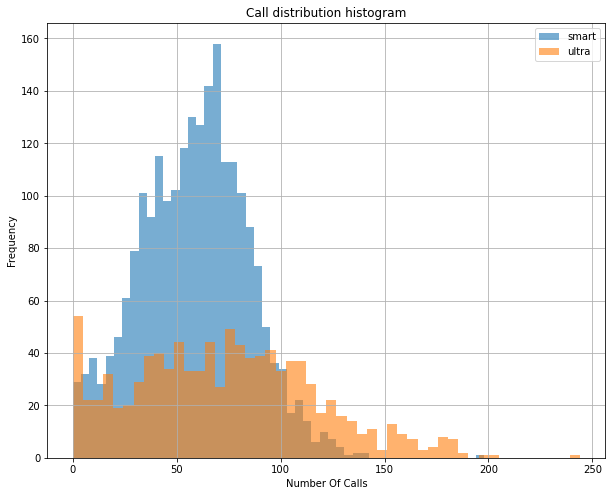

In [24]:
total_info.query('tariff=="smart"')['count_calls'].hist(alpha=0.6,figsize=(10,8),bins=50)
total_info.query('tariff=="ultra"')['count_calls'].hist(alpha=0.6,figsize=(10,8),bins=50)

plt.legend(['smart','ultra'])
plt.title('Call distribution histogram')
plt.ylabel('Frequency')
plt.xlabel('Number Of Calls');

Both distributions can be called skewed to the right, the graph shows that the variance of the number of calls in the `ultra` tariff is greater than in `smart`.

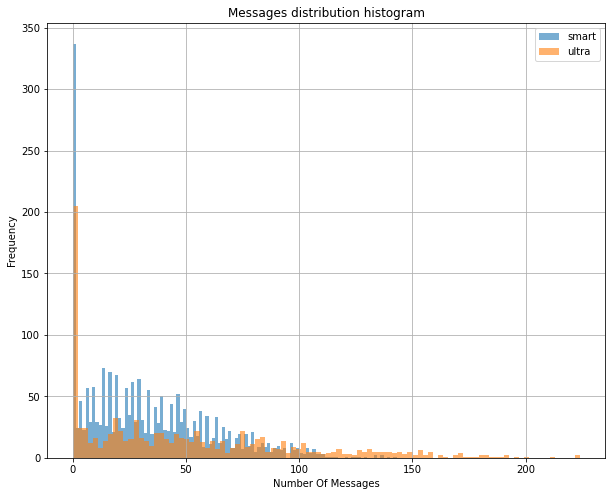

In [25]:
total_info.query('tariff=="smart"')['count_messages'].hist(alpha=0.6,figsize=(10,8),bins=100)
total_info.query('tariff=="ultra"')['count_messages'].hist(alpha=0.6,figsize=(10,8), bins=100)

plt.legend(['smart','ultra'])
plt.title('Messages distribution histogram')
plt.ylabel('Frequency')
plt.xlabel('Number Of Messages');

Both distributions can be called skewed to the right. The average value of messages in the `ultra` tariff is higher than in the `smart` tariff

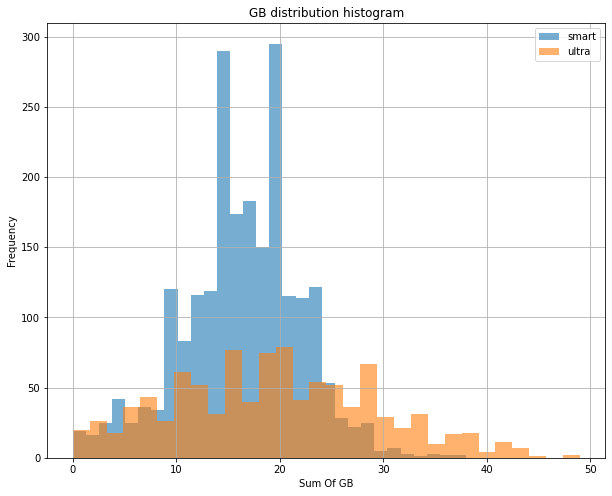

In [26]:
total_info.query('tariff=="smart"')['sum_gb'].hist(alpha=0.6,figsize=(10,8),bins=30)
total_info.query('tariff=="ultra"')['sum_gb'].hist(alpha=0.6,figsize=(10,8),bins=30)

plt.legend(['smart','ultra'])
plt.title('GB distribution histogram')
plt.ylabel('Frequency')
plt.xlabel('Sum Of GB');

Based on these distributions, it can be concluded that there are more customers in the `ultra` tariff who spend a large amount of traffic.

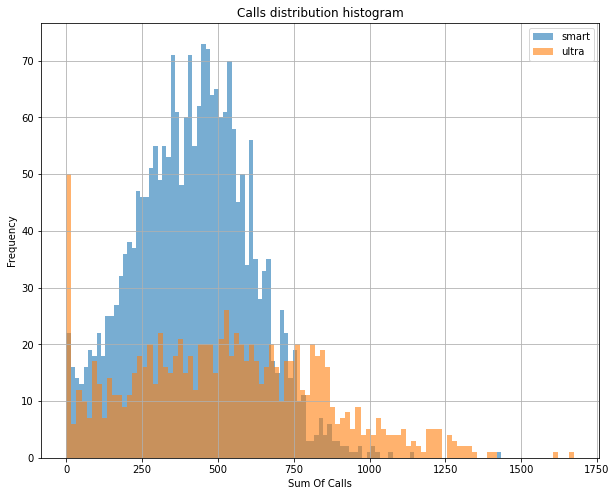

In [27]:
total_info.query('tariff=="smart"')['sum_calls'].hist(alpha=0.6,figsize=(10,8),bins=100)
total_info.query('tariff=="ultra"')['sum_calls'].hist(alpha=0.6,figsize=(10,8),bins=100)

plt.legend(['smart','ultra'])
plt.title('Calls distribution histogram')
plt.ylabel('Frequency')
plt.xlabel('Sum Of Calls');

Based on these distributions, it can be concluded that there are more customers in the `ultra` tariff who spend a large number of minutes talking.

### Conclusion

In general, based on these distributions, it can be concluded that customers with the `ultra` tariff use a larger number of calls, messages and traffic

## Step 4. Hypothesis Testing

### The first hypothesis

Null hypothesis (H0) - The average revenue of users of the `Ultra` and `Smart` tariffs is the same

Alternative hypothesis (H1) - The average revenue of users of the `Ultra` and `Smart` tariffs differs

In [28]:
alpha = 0.05

results = st.ttest_ind(total_info.query('tariff=="smart"')['revenue'], 
                       total_info.query('tariff=="ultra"')['revenue'],
                       equal_var = False)

print('p-value: ', results.pvalue)

if results.pvalue < alpha:
    print("We reject the null hypothesis")
else:
    print("It was not possible to reject the null hypothesis") 

p-value:  4.2606313931076085e-250
We reject the null hypothesis


The null hypothesis is **rejected**, the p-value is significantly less than the specified significance level

### The second hypothesis

Null hypothesis (H0) - the average revenue of users from Moscow is the same as the revenue of users from other regions

Alternative hypothesis (H1) - the average revenue of users from Moscow differs from the revenue of users from other regions

In [29]:
alpha = 0.05

results = st.ttest_ind(total_info.query('city=="Москва"')['revenue'], 
                       total_info.query('city!="Москва"')['revenue'])

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.5440152911670224
Не получилось отвергнуть нулевую гипотезу


The null hypothesis **cannot be rejected**, the p-value is significantly higher than the specified significance level

In [30]:
total_info.query('tariff=="smart"')['revenue'].describe()

count    2229.000000
mean     1289.973531
std       818.404367
min       550.000000
25%       550.000000
50%      1023.000000
75%      1750.000000
max      6770.000000
Name: revenue, dtype: float64

In [31]:
total_info.query('tariff=="ultra"')['revenue'].describe()

count     985.000000
mean     2070.152284
std       376.187114
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: revenue, dtype: float64

## General conclusion

A preliminary analysis of tariffs was carried out on a small sample of customers. The data of 500 Megalyne users were used at the disposal.

After the analysis, it can be concluded that the ultra tariff is more suitable for people who make a large number of calls, send a large number of messages and spend a large amount of Internet traffic, but it also costs more than smart.

The **most profitable tariff for the operator, of course, can be called the `ultra` tariff** - according to the results of the study, this tariff is more profitable for the company (both average and median revenue).